# Semantic Image Search with Atlas


This guide demonstrates how to use Atlas for semantic image search using the FashionMNIST dataset. You'll learn how to:
1. Load and prepare image data
2. Create an Atlas dataset with images
3. Perform semantic search queries on the images
4. Visualize search results

The example uses FashionMNIST, a dataset of 70,000 grayscale images of clothing items across 10 categories. We'll create a searchable Atlas dataset from a subset of these images and demonstrate how to perform semantic searches to find visually similar items.

## Setup

First, make sure you have the required packages installed:

In [ ]:
!pip install torchvision nomic requests pillow matplotlib

You'll also need a Nomic API key. If you don't have one, you can create one [here](https://atlas.nomic.ai/cli-login).

## Prepare Dataset

We'll start by loading the FashionMNIST dataset and creating a subset for our search index. To keep the example manageable, we'll sample approximately 5% of images from each class. This gives us a good representation of each clothing category while keeping the dataset size reasonable.

The code loads the FashionMNIST dataset, then:
1. Calculates how many samples to take from each class (5% of total)
2. Randomly samples images from each class
3. Stores the images and their metadata (class labels) in separate lists

In [33]:
from torchvision import datasets
import random

dataset = datasets.FashionMNIST(root='data', train=True, download=True)
images = []
metadata = []
samples_per_class = {}
for label in range(len(dataset.classes)):
    class_count = sum(1 for _, l in dataset if l == label)
    samples_per_class[label] = max(1, int(class_count * 0.05))
for label in range(len(dataset.classes)):
    class_indices = [i for i, (_, l) in enumerate(dataset) if l == label]
    sampled_indices = random.sample(class_indices, samples_per_class[label])
    for idx in sampled_indices:
        img, _ = dataset[idx]
        images.append(img)
        metadata.append({
            'class': dataset.classes[label]
        })

## Create Atlas Dataset

Now we'll create an Atlas dataset from our sampled images. The `map_data` function will:
1. Upload the image blobs
2. Generate embeddings for each image
3. Create a map visualization of the image space

The `identifier` parameter specifies the name for your dataset. Use `identifier="your_org_name_here/fashion_mnist_dataset"` to create it in a specific organization you're a member of.

In [ ]:
from nomic import atlas

atlas.map_data(
    blobs=images,
    data=metadata, 
    identifier='fashion_mnist_dataset' 
)

## Atlas Search API

After creating the dataset, we need three pieces of information to perform searches:
1. `DATASET_ID`: The unique identifier for your dataset
2. `PROJECTION_ID`: The ID of the projection/embedding space
3. `NOMIC_API_KEY`: Your Nomic API key for authentication

You can find the Dataset ID and Projection ID in the Atlas UI after creating your dataset.

In [36]:
DATASET_ID = "9d10d35f-540a-4f72-aea2-f7a8da07fd65"
PROJECTION_ID = "6482e7df-586d-422c-8350-020cba791ad4"
NOMIC_API_KEY = "nk-..."

We'll create two helper functions:
1. `get_closest_items`: Performs semantic search to find similar images
2. `get_image`: Retrieves the actual image data for a semantic search result

These functions use the Atlas API to query and retrieve data from our dataset. The `get_closest_items` function accepts a text query and returns the k most similar images based on their semantic embeddings.

In [38]:
import requests

def get_closest_items(query, k=3):
    url = "https://api-atlas.nomic.ai/v1/query/topk"
    headers = {
        'Content-Type': 'application/json',
        'Authorization': f'Bearer {NOMIC_API_KEY}'
    }
    payload = {
        "projection_id": PROJECTION_ID,
        "k": k,
        "query": query
    }
    response = requests.post(url, headers=headers, json=payload)
    return response.json()

In [44]:
def get_image(blob_hash):
    url = f"https://api-atlas.nomic.ai/v1/dataset/data/get/blob/{DATASET_ID}/{blob_hash}"
    headers = {
        'Accept': 'application/json',
        'Authorization': f'Bearer {NOMIC_API_KEY}'
    }
    response = requests.request("GET", url, headers=headers, data={})
    return response.json()

Now we use this function to similar images given a text query, retrieve the actual images, and display them in a grid with their class labels and similarity scores.

Try different queries like "formal", "casual", "sporty", or "fancy" to explore the semantic relationships in the image space! The similarity scores show how closely each image matches your query in the semantic embedding space.

In [46]:
import matplotlib.pyplot as plt
import urllib.request
from PIL import Image as PILImage
import numpy as np

def search_and_display_images(query, k=20):
    results = get_closest_items(query, k=k)
    rows, cols = 4, 5
    fig, axes = plt.subplots(rows, cols, figsize=(20, 16))
    for idx, item in enumerate(results['data']):
        row = idx // cols
        col = idx % cols
        image_data = get_image(item['_blob_hash'])
        with urllib.request.urlopen(image_data['url']) as url:
            image = PILImage.open(url)
            image_array = np.array(image)
        axes[row, col].imshow(image_array, cmap='gray')
        axes[row, col].axis('off')
        axes[row, col].set_title(f"Class: {item['class']}\nSimilarity: {item['_similarity']:.3f}")
    plt.tight_layout()
    plt.show()

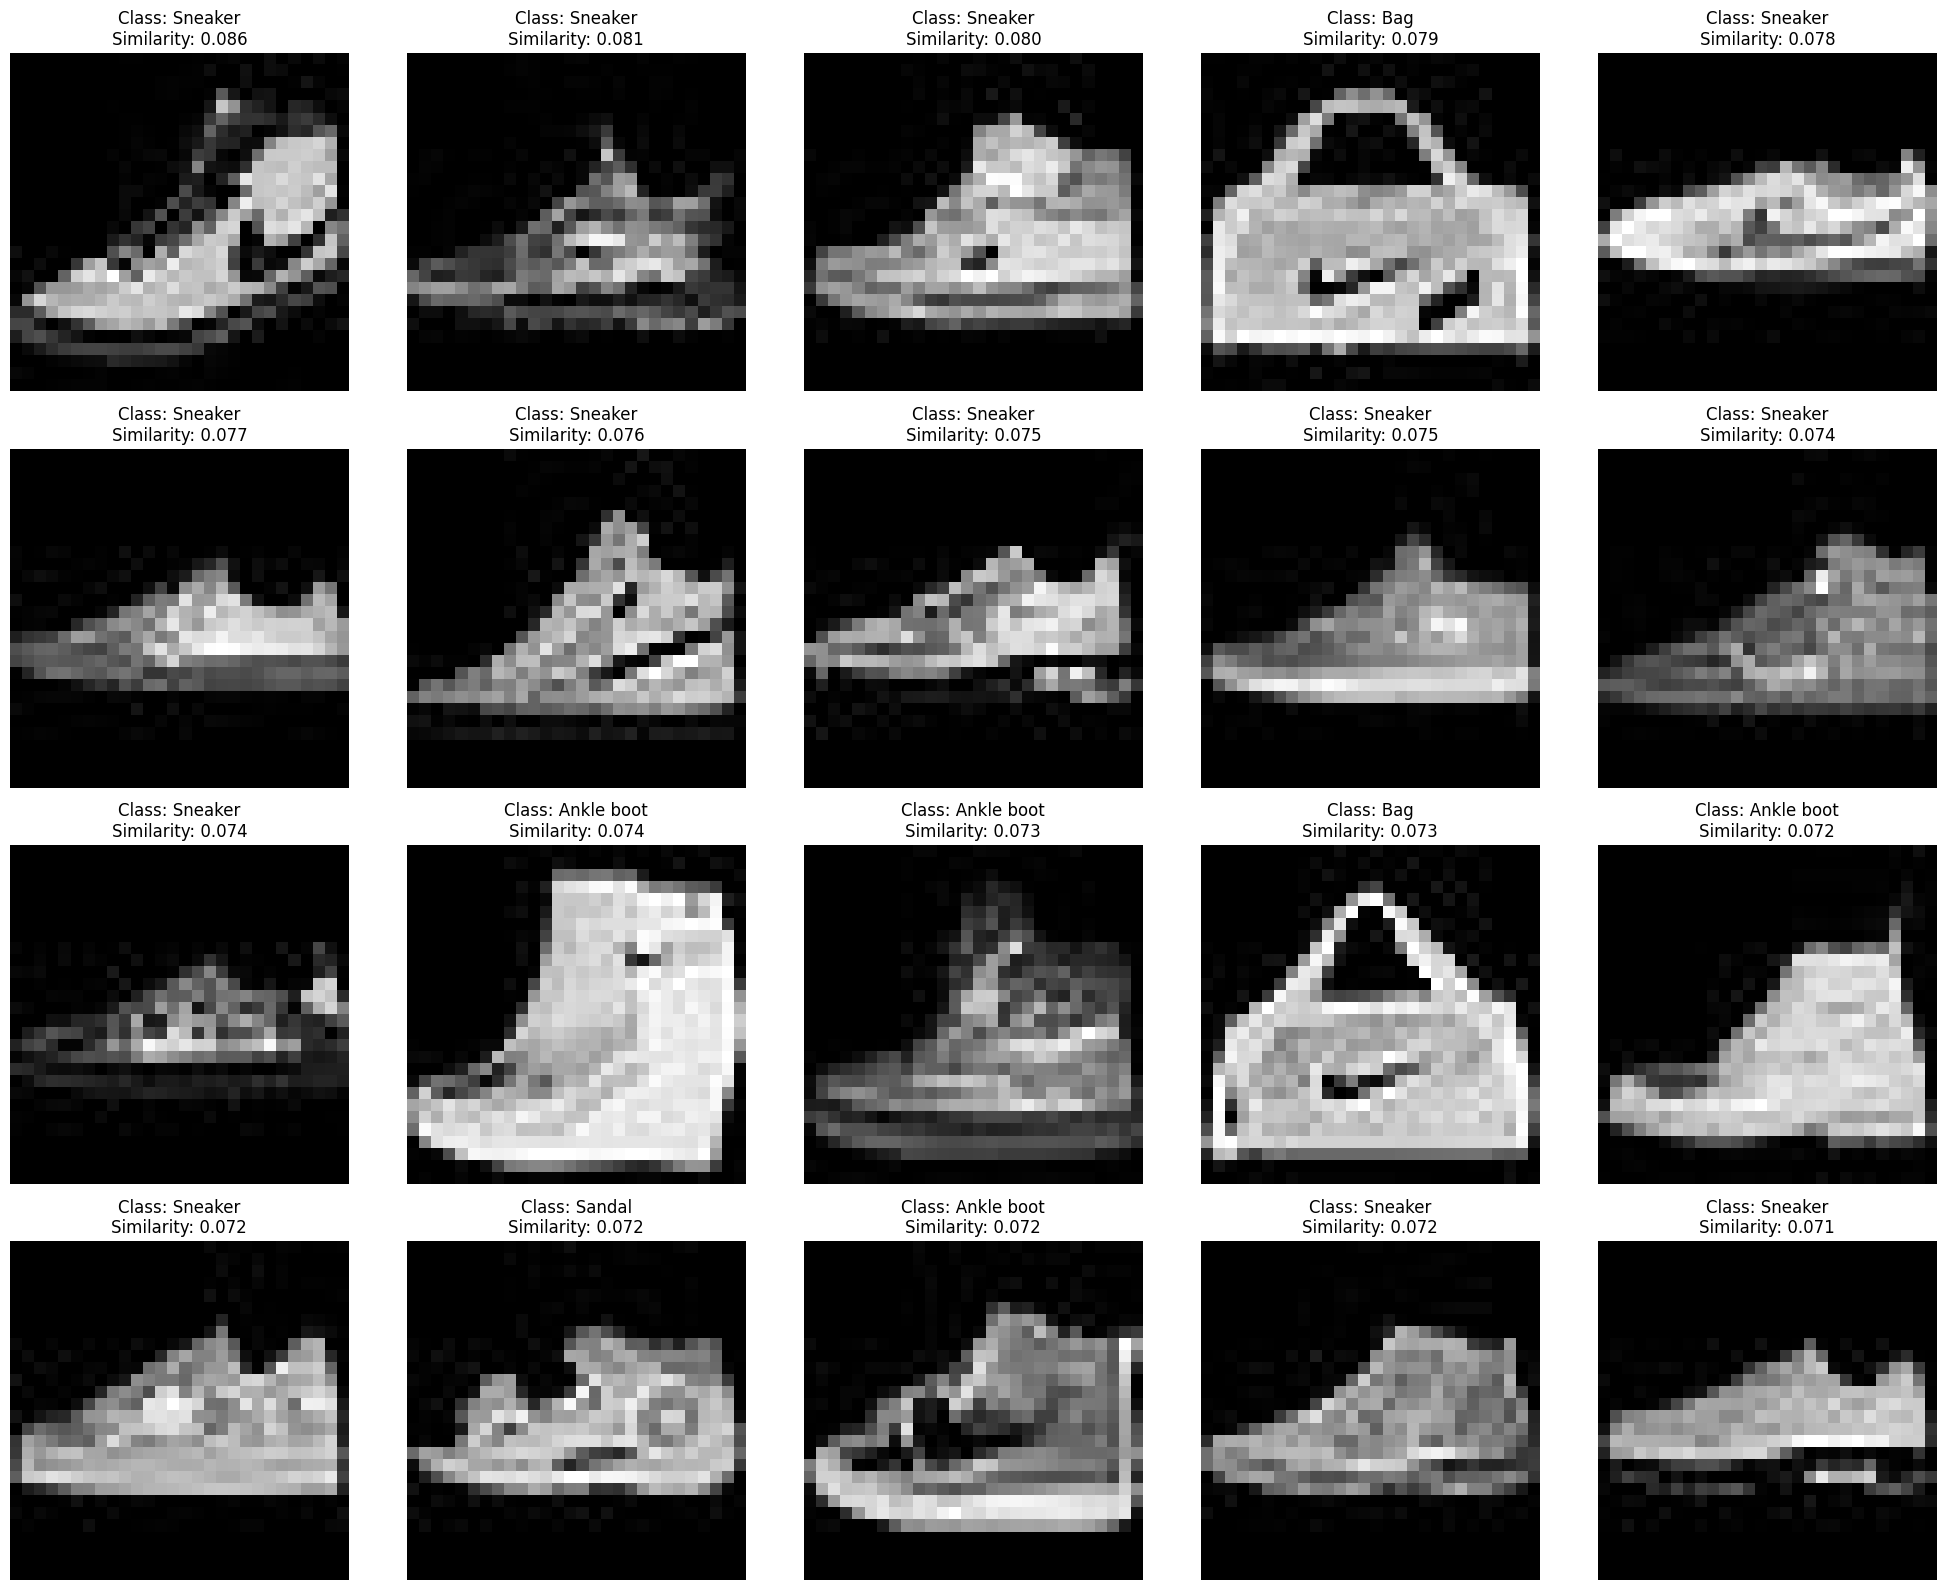

In [47]:
search_and_display_images("nikes")